In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from segmentation_models_pytorch import Unet

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

batch_size = 128
learning_rate = .00002
num_epochs = 100
loss_weights = (1.0, 1.0, .01, .01)

In [3]:
#LOAD DATASET

dataset = torch.load("dataset.pt", weights_only=False)

In [4]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#CREATE MODEL

class MultiTaskV3_1(nn.Module):
    def __init__(self):
        super().__init__()

        self.cloud_mask_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=1,
        )

        self.cloud_phase_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )
        self.cod_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )
        self.cps_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )

        self.norm0 = nn.BatchNorm2d(num_features=64)        
        self.conv0 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)


    def forward(self, x):
        x = F.relu(self.norm0(self.conv0(x)))
        cloud_mask_pred = self.cloud_mask_net(x)
        cloud_phase_pred = self.cloud_phase_net(x)
        cod_pred = self.cod_net(x)
        cps_pred = self.cps_net(x)

        cloud_phase_pred = torch.cat([cloud_mask_pred, cloud_phase_pred], dim=1)
        cod_pred = torch.cat([cloud_mask_pred, cod_pred], dim=1)
        cps_pred = torch.cat([cloud_mask_pred, cps_pred], dim=1)

        cloud_phase_pred = F.relu(self.conv1(cloud_phase_pred))
        cod_pred = F.relu(self.conv2(cod_pred))
        cps_pred = F.relu(self.conv3(cps_pred))

        return cloud_mask_pred, cloud_phase_pred, cod_pred, cps_pred

In [6]:
#FINAL SETUP

dev_str = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev_str)
model = MultiTaskV3_1().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler(device = device)

def unpack_labels(labels):
    return (
        labels[:, 0:1, :, :],             # cloud_mask → [B, H, W]
        labels[:, 1, :, :].long(),        # cloud_phase → [B, H, W]
        labels[:, 2:3, :, :],             # cod → [B, 1, H, W]
        labels[:, 3:4, :, :]              # cps → [B, 1, H, W]
    )


train_mask_losses, train_phase_losses, train_cod_losses, train_cps_losses, train_all_losses = [], [], [], [], []
val_mask_losses, val_phase_losses, val_cod_losses, val_cps_losses, val_all_losses = [], [], [], [], []

train_mask_acc, train_phase_acc, train_cod_r2, train_cps_r2 = [], [], [], []
val_mask_acc, val_phase_acc, val_cod_r2, val_cps_r2 = [], [], [], []

In [7]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader, loss_weights=(1,1,1,1)):
    model.train()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        optimizer.zero_grad()
        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        with autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            

        # Update model
        scaler.scale(total_batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(train_loader),
        'loss_mask': total_loss_mask / len(train_loader),
        'loss_phase': total_loss_phase / len(train_loader),
        'loss_cod': total_loss_cod / len(train_loader),
        'loss_cps': total_loss_cps / len(train_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }



def eval(model, val_loader, loss_weights=(1,1,1,1)):
    model.eval()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in (val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        
        with torch.no_grad(), autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            
        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(val_loader),
        'loss_mask': total_loss_mask / len(val_loader),
        'loss_phase': total_loss_phase / len(val_loader),
        'loss_cod': total_loss_cod / len(val_loader),
        'loss_cps': total_loss_cps / len(val_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }

In [8]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_results = train(model, train_loader, loss_weights = loss_weights)
    val_results = eval(model, val_loader, loss_weights = loss_weights)
    
    train_mask_losses.append(train_results['loss_mask'])
    train_phase_losses.append(train_results['loss_phase'])
    train_cod_losses.append(train_results['loss_cod'])
    train_cps_losses.append(train_results['loss_cps'])
    train_all_losses.append(train_results['loss_total'])

    train_mask_acc.append(train_results['acc_mask'])
    train_phase_acc.append(train_results['acc_phase'])
    train_cod_r2.append(train_results['r2_cod'])
    train_cps_r2.append(train_results['r2_cps'])

    val_mask_losses.append(val_results['loss_mask'])
    val_phase_losses.append(val_results['loss_phase'])
    val_cod_losses.append(val_results['loss_cod'])
    val_cps_losses.append(val_results['loss_cps'])
    val_all_losses.append(val_results['loss_total'])

    val_mask_acc.append(val_results['acc_mask'])
    val_phase_acc.append(val_results['acc_phase'])
    val_cod_r2.append(val_results['r2_cod'])
    val_cps_r2.append(val_results['r2_cps'])

    print(f"Epoch: {e} | Train Loss: {train_results['loss_total']:.4f} | Val Loss: {val_results['loss_total']:.4f} | Val Mask: {val_results['acc_mask']:.4f} | Val Phase: {val_results['acc_phase']:.4f} | Val Cod: {val_results['r2_cod']:.4f} | Val Cps: {val_results['r2_cps']:.4f}")
    

100%|██████████| 94/94 [00:30<00:00,  3.12it/s]


Epoch: 1 | Train Loss: 4.7344 | Val Loss: 4.3575 | Val Mask: 0.7808 | Val Phase: 0.5622 | Val Cod: -0.1449 | Val Cps: -0.7977


100%|██████████| 94/94 [00:27<00:00,  3.43it/s]


Epoch: 2 | Train Loss: 4.0869 | Val Loss: 3.8717 | Val Mask: 0.8922 | Val Phase: 0.6527 | Val Cod: -0.0169 | Val Cps: -0.6699


100%|██████████| 94/94 [00:27<00:00,  3.36it/s]


Epoch: 3 | Train Loss: 3.6506 | Val Loss: 3.4569 | Val Mask: 0.9172 | Val Phase: 0.6987 | Val Cod: 0.0649 | Val Cps: -0.4549


100%|██████████| 94/94 [00:28<00:00,  3.29it/s]


Epoch: 4 | Train Loss: 3.2451 | Val Loss: 3.0638 | Val Mask: 0.9186 | Val Phase: 0.7481 | Val Cod: 0.1655 | Val Cps: -0.2905


100%|██████████| 94/94 [00:28<00:00,  3.35it/s]


Epoch: 5 | Train Loss: 2.8632 | Val Loss: 2.7503 | Val Mask: 0.9302 | Val Phase: 0.7673 | Val Cod: 0.1939 | Val Cps: -0.1265


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 6 | Train Loss: 2.5360 | Val Loss: 2.6658 | Val Mask: 0.9266 | Val Phase: 0.7763 | Val Cod: 0.2180 | Val Cps: -0.1163


100%|██████████| 94/94 [00:27<00:00,  3.44it/s]


Epoch: 7 | Train Loss: 2.2637 | Val Loss: 2.4581 | Val Mask: 0.9393 | Val Phase: 0.8050 | Val Cod: 0.2360 | Val Cps: -0.0573


100%|██████████| 94/94 [00:27<00:00,  3.43it/s]


Epoch: 8 | Train Loss: 2.0445 | Val Loss: 2.5716 | Val Mask: 0.9354 | Val Phase: 0.7743 | Val Cod: 0.2567 | Val Cps: -0.0838


100%|██████████| 94/94 [00:27<00:00,  3.39it/s]


Epoch: 9 | Train Loss: 1.8560 | Val Loss: 1.9484 | Val Mask: 0.9397 | Val Phase: 0.8208 | Val Cod: 0.2652 | Val Cps: 0.2993


100%|██████████| 94/94 [00:27<00:00,  3.44it/s]


Epoch: 10 | Train Loss: 1.7084 | Val Loss: 1.8979 | Val Mask: 0.9466 | Val Phase: 0.8095 | Val Cod: 0.2527 | Val Cps: 0.3701


100%|██████████| 94/94 [00:27<00:00,  3.44it/s]


Epoch: 11 | Train Loss: 1.5973 | Val Loss: 1.9848 | Val Mask: 0.9440 | Val Phase: 0.8025 | Val Cod: 0.2737 | Val Cps: 0.2855


100%|██████████| 94/94 [00:27<00:00,  3.39it/s]


Epoch: 12 | Train Loss: 1.5037 | Val Loss: 1.7309 | Val Mask: 0.9421 | Val Phase: 0.8307 | Val Cod: 0.2795 | Val Cps: 0.4144


100%|██████████| 94/94 [00:27<00:00,  3.41it/s]


Epoch: 13 | Train Loss: 1.4396 | Val Loss: 1.6871 | Val Mask: 0.9503 | Val Phase: 0.8285 | Val Cod: 0.2580 | Val Cps: 0.4358


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 14 | Train Loss: 1.3854 | Val Loss: 2.1851 | Val Mask: 0.9504 | Val Phase: 0.6957 | Val Cod: 0.2535 | Val Cps: 0.3380


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 15 | Train Loss: 1.3415 | Val Loss: 1.6071 | Val Mask: 0.9527 | Val Phase: 0.8371 | Val Cod: 0.2956 | Val Cps: 0.4506


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 16 | Train Loss: 1.3055 | Val Loss: 1.6291 | Val Mask: 0.9527 | Val Phase: 0.8225 | Val Cod: 0.2843 | Val Cps: 0.4546


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 17 | Train Loss: 1.2690 | Val Loss: 1.5863 | Val Mask: 0.9544 | Val Phase: 0.8388 | Val Cod: 0.3146 | Val Cps: 0.4416


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 18 | Train Loss: 1.2367 | Val Loss: 1.5284 | Val Mask: 0.9538 | Val Phase: 0.8420 | Val Cod: 0.3068 | Val Cps: 0.4752


100%|██████████| 94/94 [00:27<00:00,  3.43it/s]


Epoch: 19 | Train Loss: 1.2086 | Val Loss: 1.4983 | Val Mask: 0.9544 | Val Phase: 0.8476 | Val Cod: 0.3061 | Val Cps: 0.4817


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 20 | Train Loss: 1.1846 | Val Loss: 1.5114 | Val Mask: 0.9562 | Val Phase: 0.8432 | Val Cod: 0.3106 | Val Cps: 0.4802


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 21 | Train Loss: 1.1672 | Val Loss: 1.6181 | Val Mask: 0.9552 | Val Phase: 0.8087 | Val Cod: 0.3166 | Val Cps: 0.4590


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 22 | Train Loss: 1.1505 | Val Loss: 1.5027 | Val Mask: 0.9566 | Val Phase: 0.8459 | Val Cod: 0.3099 | Val Cps: 0.4789


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 23 | Train Loss: 1.1280 | Val Loss: 1.5831 | Val Mask: 0.9566 | Val Phase: 0.8360 | Val Cod: 0.3177 | Val Cps: 0.4514


100%|██████████| 94/94 [00:27<00:00,  3.42it/s]


Epoch: 24 | Train Loss: 1.1065 | Val Loss: 1.6000 | Val Mask: 0.9556 | Val Phase: 0.8334 | Val Cod: 0.2659 | Val Cps: 0.4657


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 25 | Train Loss: 1.0953 | Val Loss: 1.4549 | Val Mask: 0.9596 | Val Phase: 0.8479 | Val Cod: 0.3173 | Val Cps: 0.4887


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 26 | Train Loss: 1.0807 | Val Loss: 1.5032 | Val Mask: 0.9590 | Val Phase: 0.8434 | Val Cod: 0.3172 | Val Cps: 0.4749


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 27 | Train Loss: 1.0605 | Val Loss: 1.4671 | Val Mask: 0.9584 | Val Phase: 0.8478 | Val Cod: 0.3208 | Val Cps: 0.4870


100%|██████████| 94/94 [00:28<00:00,  3.34it/s]


Epoch: 28 | Train Loss: 1.0514 | Val Loss: 1.4251 | Val Mask: 0.9598 | Val Phase: 0.8499 | Val Cod: 0.3217 | Val Cps: 0.4947


100%|██████████| 94/94 [00:27<00:00,  3.39it/s]


Epoch: 29 | Train Loss: 1.0368 | Val Loss: 1.4202 | Val Mask: 0.9600 | Val Phase: 0.8510 | Val Cod: 0.3259 | Val Cps: 0.4952


100%|██████████| 94/94 [00:27<00:00,  3.36it/s]


Epoch: 30 | Train Loss: 1.0270 | Val Loss: 1.4068 | Val Mask: 0.9599 | Val Phase: 0.8566 | Val Cod: 0.3215 | Val Cps: 0.4951


100%|██████████| 94/94 [00:27<00:00,  3.38it/s]


Epoch: 31 | Train Loss: 1.0244 | Val Loss: 1.4256 | Val Mask: 0.9574 | Val Phase: 0.8528 | Val Cod: 0.3351 | Val Cps: 0.4970


100%|██████████| 94/94 [00:27<00:00,  3.43it/s]


Epoch: 32 | Train Loss: 1.0037 | Val Loss: 1.4013 | Val Mask: 0.9601 | Val Phase: 0.8539 | Val Cod: 0.3234 | Val Cps: 0.4993


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 33 | Train Loss: 0.9972 | Val Loss: 1.5244 | Val Mask: 0.9582 | Val Phase: 0.8402 | Val Cod: 0.3296 | Val Cps: 0.4758


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 34 | Train Loss: 0.9859 | Val Loss: 1.4107 | Val Mask: 0.9597 | Val Phase: 0.8558 | Val Cod: 0.3178 | Val Cps: 0.4986


100%|██████████| 94/94 [00:27<00:00,  3.43it/s]


Epoch: 35 | Train Loss: 0.9726 | Val Loss: 1.3740 | Val Mask: 0.9607 | Val Phase: 0.8580 | Val Cod: 0.3314 | Val Cps: 0.5071


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 36 | Train Loss: 0.9733 | Val Loss: 1.4849 | Val Mask: 0.9595 | Val Phase: 0.8331 | Val Cod: 0.3068 | Val Cps: 0.4727


100%|██████████| 94/94 [00:27<00:00,  3.41it/s]


Epoch: 37 | Train Loss: 0.9595 | Val Loss: 1.4779 | Val Mask: 0.9603 | Val Phase: 0.8464 | Val Cod: 0.3349 | Val Cps: 0.4825


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 38 | Train Loss: 0.9438 | Val Loss: 1.3546 | Val Mask: 0.9610 | Val Phase: 0.8603 | Val Cod: 0.3464 | Val Cps: 0.5143


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 39 | Train Loss: 0.9301 | Val Loss: 1.4657 | Val Mask: 0.9621 | Val Phase: 0.8308 | Val Cod: 0.3426 | Val Cps: 0.4709


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 40 | Train Loss: 0.9301 | Val Loss: 1.8193 | Val Mask: 0.9559 | Val Phase: 0.8187 | Val Cod: 0.3116 | Val Cps: 0.4101


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 41 | Train Loss: 0.9278 | Val Loss: 1.3508 | Val Mask: 0.9625 | Val Phase: 0.8607 | Val Cod: 0.3351 | Val Cps: 0.5123


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 42 | Train Loss: 0.9103 | Val Loss: 1.3598 | Val Mask: 0.9616 | Val Phase: 0.8561 | Val Cod: 0.3500 | Val Cps: 0.5076


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 43 | Train Loss: 0.9024 | Val Loss: 1.5022 | Val Mask: 0.9619 | Val Phase: 0.8442 | Val Cod: 0.3536 | Val Cps: 0.4817


100%|██████████| 94/94 [00:27<00:00,  3.41it/s]


Epoch: 44 | Train Loss: 0.9025 | Val Loss: 1.3454 | Val Mask: 0.9625 | Val Phase: 0.8624 | Val Cod: 0.3482 | Val Cps: 0.5112


100%|██████████| 94/94 [00:28<00:00,  3.36it/s]


Epoch: 45 | Train Loss: 0.8946 | Val Loss: 1.3652 | Val Mask: 0.9613 | Val Phase: 0.8535 | Val Cod: 0.3454 | Val Cps: 0.5108


100%|██████████| 94/94 [00:27<00:00,  3.36it/s]


Epoch: 46 | Train Loss: 0.8860 | Val Loss: 1.4003 | Val Mask: 0.9619 | Val Phase: 0.8419 | Val Cod: 0.3543 | Val Cps: 0.5039


100%|██████████| 94/94 [00:27<00:00,  3.42it/s]


Epoch: 47 | Train Loss: 0.8748 | Val Loss: 1.3331 | Val Mask: 0.9631 | Val Phase: 0.8636 | Val Cod: 0.3398 | Val Cps: 0.5158


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 48 | Train Loss: 0.8781 | Val Loss: 1.5087 | Val Mask: 0.9619 | Val Phase: 0.8442 | Val Cod: 0.3575 | Val Cps: 0.4769


100%|██████████| 94/94 [00:27<00:00,  3.44it/s]


Epoch: 49 | Train Loss: 0.8594 | Val Loss: 1.3594 | Val Mask: 0.9633 | Val Phase: 0.8612 | Val Cod: 0.3638 | Val Cps: 0.5104


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 50 | Train Loss: 0.8735 | Val Loss: 1.3549 | Val Mask: 0.9603 | Val Phase: 0.8598 | Val Cod: 0.3441 | Val Cps: 0.5095


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 51 | Train Loss: 0.8602 | Val Loss: 1.3471 | Val Mask: 0.9609 | Val Phase: 0.8584 | Val Cod: 0.3563 | Val Cps: 0.5116


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 52 | Train Loss: 0.8564 | Val Loss: 1.3272 | Val Mask: 0.9617 | Val Phase: 0.8627 | Val Cod: 0.3704 | Val Cps: 0.5200


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 53 | Train Loss: 0.8466 | Val Loss: 1.4411 | Val Mask: 0.9628 | Val Phase: 0.8326 | Val Cod: 0.3305 | Val Cps: 0.4899


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 54 | Train Loss: 0.8364 | Val Loss: 1.3060 | Val Mask: 0.9643 | Val Phase: 0.8640 | Val Cod: 0.3728 | Val Cps: 0.5195


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 55 | Train Loss: 0.8273 | Val Loss: 1.3126 | Val Mask: 0.9624 | Val Phase: 0.8640 | Val Cod: 0.3776 | Val Cps: 0.5245


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 56 | Train Loss: 0.8265 | Val Loss: 1.3841 | Val Mask: 0.9624 | Val Phase: 0.8553 | Val Cod: 0.3822 | Val Cps: 0.5084


100%|██████████| 94/94 [00:27<00:00,  3.39it/s]


Epoch: 57 | Train Loss: 0.8263 | Val Loss: 1.3579 | Val Mask: 0.9641 | Val Phase: 0.8589 | Val Cod: 0.3733 | Val Cps: 0.5163


100%|██████████| 94/94 [00:28<00:00,  3.35it/s]


Epoch: 58 | Train Loss: 0.8147 | Val Loss: 1.3179 | Val Mask: 0.9639 | Val Phase: 0.8657 | Val Cod: 0.3719 | Val Cps: 0.5227


100%|██████████| 94/94 [00:27<00:00,  3.38it/s]


Epoch: 59 | Train Loss: 0.8115 | Val Loss: 1.3227 | Val Mask: 0.9643 | Val Phase: 0.8631 | Val Cod: 0.3841 | Val Cps: 0.5217


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 60 | Train Loss: 0.8126 | Val Loss: 1.3262 | Val Mask: 0.9639 | Val Phase: 0.8609 | Val Cod: 0.3801 | Val Cps: 0.5255


100%|██████████| 94/94 [00:27<00:00,  3.44it/s]


Epoch: 61 | Train Loss: 0.8026 | Val Loss: 1.2870 | Val Mask: 0.9642 | Val Phase: 0.8671 | Val Cod: 0.3931 | Val Cps: 0.5293


100%|██████████| 94/94 [00:27<00:00,  3.41it/s]


Epoch: 62 | Train Loss: 0.8003 | Val Loss: 1.3247 | Val Mask: 0.9635 | Val Phase: 0.8643 | Val Cod: 0.3811 | Val Cps: 0.5120


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 63 | Train Loss: 0.7958 | Val Loss: 1.3487 | Val Mask: 0.9643 | Val Phase: 0.8623 | Val Cod: 0.3845 | Val Cps: 0.5122


100%|██████████| 94/94 [00:27<00:00,  3.36it/s]


Epoch: 64 | Train Loss: 0.7910 | Val Loss: 1.2953 | Val Mask: 0.9650 | Val Phase: 0.8648 | Val Cod: 0.3826 | Val Cps: 0.5300


100%|██████████| 94/94 [00:27<00:00,  3.37it/s]


Epoch: 65 | Train Loss: 0.7879 | Val Loss: 1.3844 | Val Mask: 0.9623 | Val Phase: 0.8445 | Val Cod: 0.3849 | Val Cps: 0.4957


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 66 | Train Loss: 0.7837 | Val Loss: 1.2960 | Val Mask: 0.9627 | Val Phase: 0.8636 | Val Cod: 0.3871 | Val Cps: 0.5293


100%|██████████| 94/94 [00:27<00:00,  3.43it/s]


Epoch: 67 | Train Loss: 0.7758 | Val Loss: 1.3612 | Val Mask: 0.9647 | Val Phase: 0.8591 | Val Cod: 0.3923 | Val Cps: 0.5206


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 68 | Train Loss: 0.7815 | Val Loss: 1.4924 | Val Mask: 0.9636 | Val Phase: 0.8437 | Val Cod: 0.4045 | Val Cps: 0.4993


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 69 | Train Loss: 0.7729 | Val Loss: 1.4307 | Val Mask: 0.9644 | Val Phase: 0.8535 | Val Cod: 0.3888 | Val Cps: 0.5029


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 70 | Train Loss: 0.7652 | Val Loss: 1.2771 | Val Mask: 0.9654 | Val Phase: 0.8704 | Val Cod: 0.3955 | Val Cps: 0.5288


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 71 | Train Loss: 0.7650 | Val Loss: 1.3438 | Val Mask: 0.9642 | Val Phase: 0.8520 | Val Cod: 0.3853 | Val Cps: 0.5150


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 72 | Train Loss: 0.7552 | Val Loss: 1.2778 | Val Mask: 0.9655 | Val Phase: 0.8671 | Val Cod: 0.3872 | Val Cps: 0.5330


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 73 | Train Loss: 0.7633 | Val Loss: 1.3082 | Val Mask: 0.9650 | Val Phase: 0.8644 | Val Cod: 0.4020 | Val Cps: 0.5298


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 74 | Train Loss: 0.7617 | Val Loss: 1.4554 | Val Mask: 0.9617 | Val Phase: 0.8196 | Val Cod: 0.3672 | Val Cps: 0.5121


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 75 | Train Loss: 0.7770 | Val Loss: 1.3284 | Val Mask: 0.9651 | Val Phase: 0.8626 | Val Cod: 0.4020 | Val Cps: 0.5195


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 76 | Train Loss: 0.7512 | Val Loss: 1.4719 | Val Mask: 0.9647 | Val Phase: 0.8096 | Val Cod: 0.3668 | Val Cps: 0.5049


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 77 | Train Loss: 0.7465 | Val Loss: 1.2590 | Val Mask: 0.9661 | Val Phase: 0.8700 | Val Cod: 0.4101 | Val Cps: 0.5385


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 78 | Train Loss: 0.7406 | Val Loss: 1.3071 | Val Mask: 0.9664 | Val Phase: 0.8655 | Val Cod: 0.3970 | Val Cps: 0.5241


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 79 | Train Loss: 0.7405 | Val Loss: 1.3077 | Val Mask: 0.9648 | Val Phase: 0.8645 | Val Cod: 0.4011 | Val Cps: 0.5332


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 80 | Train Loss: 0.7314 | Val Loss: 1.3711 | Val Mask: 0.9659 | Val Phase: 0.8618 | Val Cod: 0.4075 | Val Cps: 0.5114


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 81 | Train Loss: 0.7336 | Val Loss: 1.2519 | Val Mask: 0.9669 | Val Phase: 0.8704 | Val Cod: 0.4153 | Val Cps: 0.5402


100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Epoch: 82 | Train Loss: 0.7297 | Val Loss: 1.2711 | Val Mask: 0.9667 | Val Phase: 0.8676 | Val Cod: 0.4077 | Val Cps: 0.5365


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 83 | Train Loss: 0.7258 | Val Loss: 1.3114 | Val Mask: 0.9602 | Val Phase: 0.8611 | Val Cod: 0.4094 | Val Cps: 0.5340


100%|██████████| 94/94 [00:27<00:00,  3.42it/s]


Epoch: 84 | Train Loss: 0.7249 | Val Loss: 1.3310 | Val Mask: 0.9648 | Val Phase: 0.8545 | Val Cod: 0.4090 | Val Cps: 0.5136


100%|██████████| 94/94 [00:28<00:00,  3.34it/s]


Epoch: 85 | Train Loss: 0.7236 | Val Loss: 1.4920 | Val Mask: 0.9615 | Val Phase: 0.8487 | Val Cod: 0.4102 | Val Cps: 0.4883


100%|██████████| 94/94 [00:28<00:00,  3.36it/s]


Epoch: 86 | Train Loss: 0.7206 | Val Loss: 1.2624 | Val Mask: 0.9665 | Val Phase: 0.8702 | Val Cod: 0.4040 | Val Cps: 0.5386


100%|██████████| 94/94 [00:27<00:00,  3.39it/s]


Epoch: 87 | Train Loss: 0.7178 | Val Loss: 1.2569 | Val Mask: 0.9665 | Val Phase: 0.8707 | Val Cod: 0.4219 | Val Cps: 0.5367


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 88 | Train Loss: 0.7116 | Val Loss: 1.2552 | Val Mask: 0.9668 | Val Phase: 0.8691 | Val Cod: 0.4061 | Val Cps: 0.5404


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 89 | Train Loss: 0.7152 | Val Loss: 1.2540 | Val Mask: 0.9671 | Val Phase: 0.8700 | Val Cod: 0.4223 | Val Cps: 0.5349


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 90 | Train Loss: 0.7100 | Val Loss: 1.4432 | Val Mask: 0.9653 | Val Phase: 0.8507 | Val Cod: 0.4160 | Val Cps: 0.5094


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 91 | Train Loss: 0.7060 | Val Loss: 1.5078 | Val Mask: 0.9660 | Val Phase: 0.8076 | Val Cod: 0.3948 | Val Cps: 0.4728


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 92 | Train Loss: 0.7086 | Val Loss: 1.2664 | Val Mask: 0.9671 | Val Phase: 0.8713 | Val Cod: 0.3950 | Val Cps: 0.5342


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 93 | Train Loss: 0.7073 | Val Loss: 1.3363 | Val Mask: 0.9670 | Val Phase: 0.8623 | Val Cod: 0.4291 | Val Cps: 0.5258


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 94 | Train Loss: 0.7011 | Val Loss: 1.2939 | Val Mask: 0.9671 | Val Phase: 0.8690 | Val Cod: 0.4206 | Val Cps: 0.5280


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 95 | Train Loss: 0.7040 | Val Loss: 1.2865 | Val Mask: 0.9673 | Val Phase: 0.8689 | Val Cod: 0.4155 | Val Cps: 0.5325


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 96 | Train Loss: 0.6938 | Val Loss: 1.2655 | Val Mask: 0.9671 | Val Phase: 0.8645 | Val Cod: 0.4170 | Val Cps: 0.5335


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 97 | Train Loss: 0.6979 | Val Loss: 1.3065 | Val Mask: 0.9674 | Val Phase: 0.8522 | Val Cod: 0.4148 | Val Cps: 0.5306


100%|██████████| 94/94 [00:27<00:00,  3.44it/s]


Epoch: 98 | Train Loss: 0.6867 | Val Loss: 1.2779 | Val Mask: 0.9664 | Val Phase: 0.8649 | Val Cod: 0.4129 | Val Cps: 0.5311


100%|██████████| 94/94 [00:27<00:00,  3.42it/s]


Epoch: 99 | Train Loss: 0.6934 | Val Loss: 1.6288 | Val Mask: 0.9659 | Val Phase: 0.7815 | Val Cod: 0.4225 | Val Cps: 0.4433


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 100 | Train Loss: 0.6903 | Val Loss: 1.2635 | Val Mask: 0.9672 | Val Phase: 0.8666 | Val Cod: 0.4206 | Val Cps: 0.5377


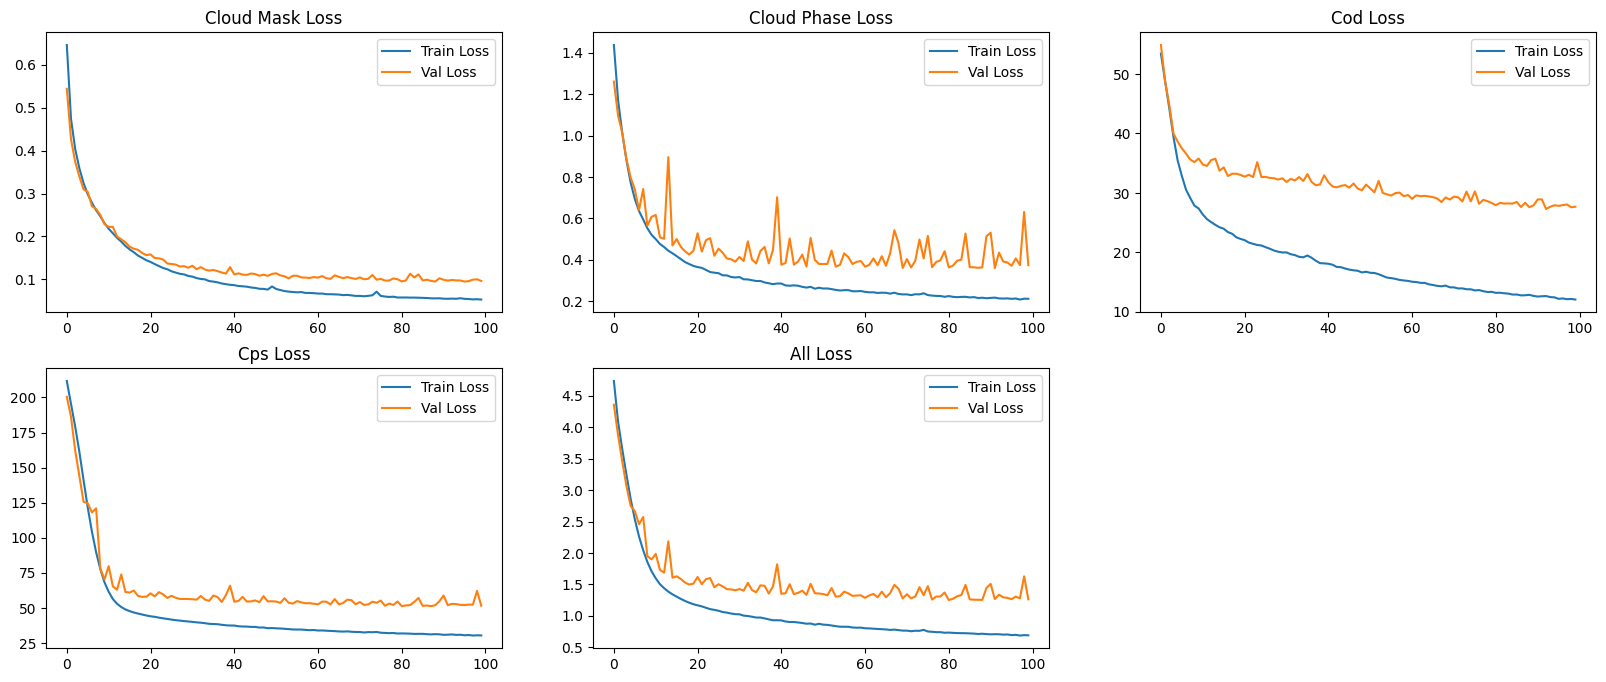

In [9]:
#PLOT LOSS

plt.figure(figsize=(20,8))

plt.subplot(2, 3, 1)
plt.plot(train_mask_losses, label='Train Loss')
plt.plot(val_mask_losses, label='Val Loss')
plt.title('Cloud Mask Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(train_phase_losses, label='Train Loss')
plt.plot(val_phase_losses, label='Val Loss')
plt.title('Cloud Phase Loss')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(train_cod_losses, label='Train Loss')
plt.plot(val_cod_losses, label='Val Loss')
plt.title('Cod Loss')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(train_cps_losses, label='Train Loss')
plt.plot(val_cps_losses, label='Val Loss')
plt.title('Cps Loss')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(train_all_losses, label='Train Loss')
plt.plot(val_all_losses, label='Val Loss')
plt.title('All Loss')
plt.legend()

plt.savefig("./graphs/MultiTaskV3.1_loss.png")  

plt.show()

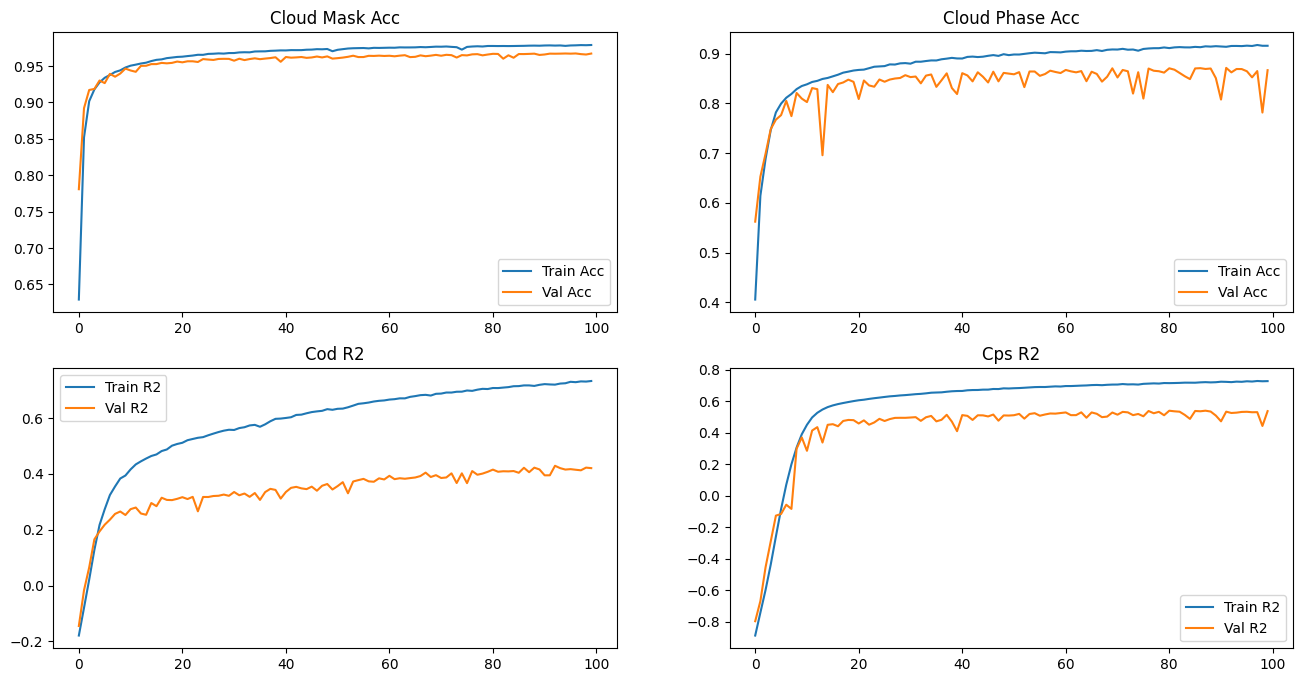

In [16]:
#PLOT ACCURACY

plt.figure(figsize=(16,8))

plt.subplot(2, 2, 1)
plt.plot(train_mask_acc, label='Train Acc')
plt.plot(val_mask_acc, label='Val Acc')
plt.title('Cloud Mask Acc')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_phase_acc, label='Train Acc')
plt.plot(val_phase_acc, label='Val Acc')
plt.title('Cloud Phase Acc')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_cod_r2, label='Train R2')
plt.plot(val_cod_r2, label='Val R2')
plt.title('Cod R2')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_cps_r2, label='Train R2')
plt.plot(val_cps_r2, label='Val R2')
plt.title('Cps R2')
plt.legend()

plt.savefig("./graphs/MultiTaskV3.1_acc.png")  

plt.show()


In [18]:
# MODEL EVALUATION — CLOUD MASK

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        cloud_mask_target, _, _, _ = unpack_labels(labels)
        cloud_mask_pred, _, _, _ = model(images)

        probs = torch.sigmoid(cloud_mask_pred)
        preds = (probs > 0.5).long()

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_mask_target.cpu().numpy())

# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(
    all_labels, all_preds,
    labels=[0, 1],
    digits=3,
    output_dict=True,
    zero_division=0
)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(2)])
supports = np.array([report[str(i)]['support'] for i in range(2)])
iou = f1_scores / (2 - f1_scores)


# Output
print("CLOUD MASK REPORT:\n", classification_report(all_labels, all_preds, labels=[0, 1], digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds, labels=[0, 1]))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))

100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


CLOUD MASK REPORT:
               precision    recall  f1-score   support

           0      0.935     0.919     0.927   5238099
           1      0.978     0.983     0.980  19337901

    accuracy                          0.969  24576000
   macro avg      0.957     0.951     0.954  24576000
weighted avg      0.969     0.969     0.969  24576000

CONFUSION MATRIX:
 [[ 4812908   425191]
 [  335083 19002818]]

IOU: [0.8635835  0.96153061]
Unweighted IoU: 0.9125570557842511
Weighted IoU: 0.9406542841601542


In [12]:
# MODEL EVALUATION — CLOUD PHASE

num_classes = 5

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        _, cloud_phase_target, _, _ = unpack_labels(labels)
        _, cloud_phase_pred, _, _ = model(images)
        preds = torch.argmax(cloud_phase_pred, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_phase_target.cpu().numpy())
        
# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(all_labels, all_preds, digits=3, output_dict=True)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(num_classes)])
supports = np.array([report[str(i)]['support'] for i in range(num_classes)])
iou = f1_scores / (2 - f1_scores)

# Output
print("CLOUD PHASE REPORT:\n", classification_report(all_labels, all_preds, digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))


100%|██████████| 12/12 [00:01<00:00,  7.15it/s]


CLOUD PHASE REPORT:
               precision    recall  f1-score   support

           0      0.894     0.909     0.902   3997151
           1      0.889     0.932     0.910  10880643
           2      0.894     0.782     0.834   3571657
           3      0.557     0.490     0.521   1089973
           4      0.880     0.879     0.880   5036576

    accuracy                          0.876  24576000
   macro avg      0.823     0.798     0.809  24576000
weighted avg      0.874     0.876     0.874  24576000

CONFUSION MATRIX:
 [[ 3634200   321422     6417     7041    28071]
 [  375427 10136792   103674    21168   243582]
 [    2902   455329  2792672   253555    67199]
 [    1522   100745   188340   533909   265457]
 [   49625   384872    31480   142944  4427655]]

IOU: [0.82098627 0.83478406 0.71578196 0.3524894  0.78492205]
Unweighted IoU: 0.7017927483761079
Weighted IoU: 0.7836362527930342


In [13]:
# MODEL EVALUATION — CLOUD OPTICAL DISTANCE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, cod_target, _ = unpack_labels(labels)
        _, _, cod_pred, _ = model(images)
        
        all_preds.append(cod_pred.cpu().numpy().reshape(-1))
        all_labels.append(cod_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:01<00:00,  7.17it/s]


r2: 0.38193750381469727
MSE: 27.79370880126953


In [14]:
# MODEL EVALUATION — CLOUD PARTICLE SIZE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, _, cps_target = unpack_labels(labels)
        _, _, _, cps_pred = model(images)
        
        all_preds.append(cps_pred.cpu().numpy().reshape(-1))
        all_labels.append(cps_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:01<00:00,  7.23it/s]


r2: 0.5498917102813721
MSE: 51.601261138916016


In [15]:
my_image = images[0].cpu().numpy()
my_image = np.transpose(my_image, (1, 2, 0))
phase_pred = preds[0].cpu().numpy()
phase_target = cloud_phase_target[0].cpu().numpy()



from netCDF4 import Dataset
import numpy as np


with Dataset('./maps/image1.nc', 'w', format='NETCDF4') as ds:
    ds.createDimension('x', my_image.shape[0])
    ds.createDimension('y', my_image.shape[1])
    ds.createDimension('band', my_image.shape[2])

    var = ds.createVariable('radiance', 'f4', ('x', 'y', 'band'))
    var[:] = my_image

    var.units = 'unknown'  # optional metadata

with Dataset('./maps/image2.nc', 'w', format='NETCDF4') as ds:
    ds.createDimension('x', phase_pred.shape[0])
    ds.createDimension('y', phase_pred.shape[1])

    var = ds.createVariable('prediction', 'f4', ('x', 'y'))
    var[:] = phase_pred

    var.units = 'unknown'  # optional metadata


with Dataset('./maps/image3.nc', 'w', format='NETCDF4') as ds:
    ds.createDimension('x', phase_target.shape[0])
    ds.createDimension('y', phase_target.shape[1])

    var = ds.createVariable('target', 'f4', ('x', 'y'))
    var[:] = phase_target

    var.units = 'unknown'  # optional metadata

